Imports

In [3]:
import re
import string
from nltk.corpus import stopwords
from stemming.porter2 import stem
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from math import log2

Load & prepare words

In [4]:
with open("witcher.txt", encoding="UTF-8") as file:
    text = file.read()

chapters = re.split("CHAPTER [A-Z]+\s+", text)
chapters = chapters[1:]

stop_words = stopwords.words("english")
words = [[] for _ in chapters]
for i in range(len(chapters)):
    words[i] = [word.lower() for word in chapters[i].split()]
    words[i] = [word for word in words[i] if word not in stop_words]
    words[i] = [word.translate(str.maketrans("", "", string.punctuation)) for word in words[i]]
    words[i] = [word for word in words[i] if word not in stop_words and len(word) > 1]
    # words[i] = [stem(word) for word in words[i]]

Create word pairs

In [5]:
pairs = [[] for _ in chapters]
freq_dicts = [{} for _ in chapters]
for i in range(len(chapters)):
    for word in words[i]:
        if word in freq_dicts[i]:
            freq_dicts[i][word] += 1
        else:
            freq_dicts[i][word] = 1
    pairs[i] = [(key, value) for (key, value) in freq_dicts[i].items()]
    occurrences = lambda pair: pair[1]
    pairs[i].sort(key=occurrences, reverse=True)

TF-IDF

In [23]:
tfidf_pairs = [[] for _ in chapters]
num_of_docs = len(chapters)
for i in range(num_of_docs):
    for word, count in pairs[i]:
        num_of_docs_with_word = sum([1 for j in range(num_of_docs) if word in freq_dicts[j]])
        tf_val = count
        idf_val = log2(num_of_docs / num_of_docs_with_word)
        tfidf_pairs[i].append((word, tf_val * idf_val))

    occurrences = lambda pair: pair[1]
    tfidf_pairs[i].sort(key=occurrences, reverse=True)

Word Clouds

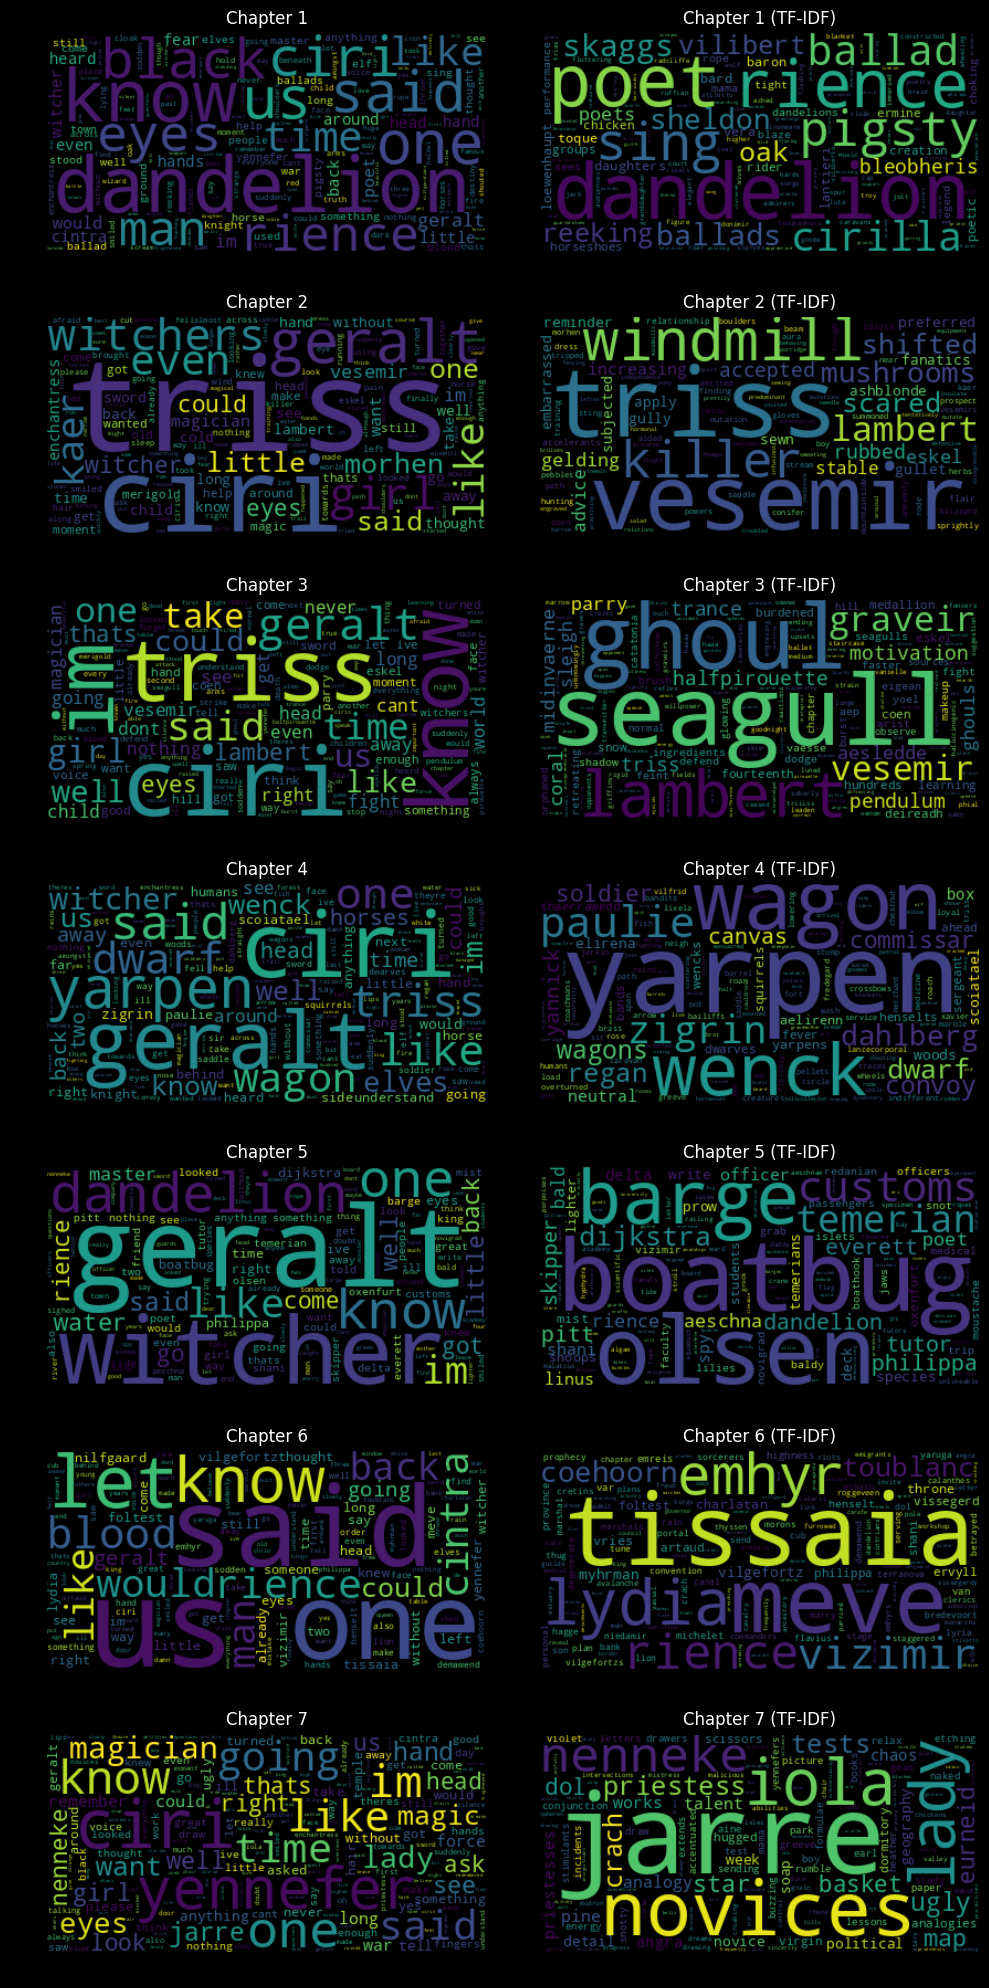

In [7]:
fig, axs = plt.subplots(7, 2, figsize=(10, 20))
fig.patch.set_facecolor('black')
for i, ax in enumerate(axs.flatten()):
    if i % 2 == 0:
        wordcloud = WordCloud().generate_from_frequencies(dict(pairs[i // 2]))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Chapter {i // 2 + 1}", color='white')
    else:
        wordcloud = WordCloud().generate_from_frequencies(dict(tfidf_pairs[i // 2]))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Chapter {i // 2 + 1} (TF-IDF)", color='white')
    
plt.tight_layout()
plt.savefig('img/cloud_chapters.png')
plt.show()

Chapters matching word

In [39]:
def match_chapters(word):
    num_of_docs = len(chapters)
    num_of_docs_with_word = sum([1 for i in range(num_of_docs) if word in freq_dicts[i]])
    idf_val = log2(num_of_docs / num_of_docs_with_word) if num_of_docs_with_word > 0 else 0
    tf_values = []
    for i in range(num_of_docs):
        if word in freq_dicts[i]:
            tf_values.append((i, freq_dicts[i][word]))
        else:
            tf_values.append((i, 0))
    occurrences = lambda pair: pair[1]
    tf_values.sort(key=occurrences, reverse=True)
    print(f"IDF = {idf_val:.3f} ({num_of_docs_with_word} out of {num_of_docs})")
    for (i, val) in tf_values:
        print(f"Chapter {i+1}: TF = {val}, TF-IDF = {val * idf_val}")

In [41]:
match_chapters("dandelion")

IDF = 0.807 (4 out of 7)
Chapter 1: TF = 68, TF-IDF = 54.900134699917075
Chapter 5: TF = 58, TF-IDF = 46.826585479341034
Chapter 6: TF = 10, TF-IDF = 8.07354922057604
Chapter 7: TF = 1, TF-IDF = 0.8073549220576041
Chapter 2: TF = 0, TF-IDF = 0.0
Chapter 3: TF = 0, TF-IDF = 0.0
Chapter 4: TF = 0, TF-IDF = 0.0
